# How do Announcments of Potential Future Airbnb Regulations Influence Airbnb Hosts' Current Listing Prices and Supply Decisions?: Evidence from Boston, MA
### By: Eli Easton


## Introduction

## Data Cleaning & Loading

In [103]:
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds

#Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

#Load calendar dataset
calendar = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)
#Clean "price column"
calendar["price"] = calendar["price"].astype(str).str.replace("$", "").str.replace(".00", 
                                                                                   "").str.replace(",", "").astype(float)
#Create "year_month" column from the "date" column in "df_calendar" dataset
calendar["date"] = pd.to_datetime(calendar["date"])
calendar["year_month"] = calendar["date"].dt.to_period('M')

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "street", "neighbourhood", "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", "first_review", "last_review", "review_scores_accuracy", 
                       "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                       "review_scores_value", "requires_license", "license", "jurisdiction_names", "instant_bookable", 
                       "cancellation_policy", "require_guest_profile_picture", "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", "city", "security_deposit", 
                       "price", "number_of_reviews"], inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})
#Room type
listings["Entire Home/Apartment"] = listings["room_type"].map({"Entire home/apt": 1}).fillna(0).astype(int)
listings["Private Room"] = listings["room_type"].map({"Private room": 1}).fillna(0).astype(int)
listings["Shared Room"] = listings["room_type"].map({"Shared room": 1}).fillna(0).astype(int)
#Property type
listings["Apartment"] = listings["property_type"].map({"Apartment": 1}).fillna(0).astype(int)
listings["House"] = listings["property_type"].map({"House": 1}).fillna(0).astype(int)
listings["Condominium"] = listings["property_type"].map({"Condominium": 1}).fillna(0).astype(int)
listings["Townhouse"] = listings["property_type"].map({"Townhouse": 1}).fillna(0).astype(int)
listings["Guesthouse"] = listings["property_type"].map({"Guesthouse": 1}).fillna(0).astype(int)
listings["Loft"] = listings["property_type"].map({"Loft": 1}).fillna(0).astype(int)
listings["Villa"] = listings["property_type"].map({"Villa": 1}).fillna(0).astype(int)
listings["Dorm"] = listings["property_type"].map({"Dorm": 1}).fillna(0).astype(int)
listings["Entire Floor"] = listings["property_type"].map({"Entire Floor": 1}).fillna(0).astype(int)
listings["Bed & Breakfast"] = listings["property_type"].map({"Bed & Breakfast": 1}).fillna(0).astype(int)
listings["Boat"] = listings["property_type"].map({"Boat": 1}).fillna(0).astype(int)
listings["Camper/RV"] = listings["property_type"].map({"Camper/RV": 1}).fillna(0).astype(int)
listings["Other"] = listings["property_type"].map({"Other": 1}).fillna(0).astype(int)
#Bed type
listings["Real Bed"] = listings["bed_type"].map({"Real Bed": 1}).fillna(0).astype(int)
listings["Futon"] = listings["bed_type"].map({"Futon": 1}).fillna(0).astype(int)
listings["Pull-out Sofa"] = listings["bed_type"].map({"Pull-out Sofa": 1}).fillna(0).astype(int)
listings["Couch"] = listings["bed_type"].map({"Couch": 1}).fillna(0).astype(int)
listings["Airbed"] = listings["bed_type"].map({"Airbed": 1}).fillna(0).astype(int)


#Merge datasets
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

cal_lis


,id,date,available,price,year_month,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,...,Entire Floor,Bed & Breakfast,Boat,Camper/RV,Other,Real Bed,Futon,Pull-out Sofa,Couch,Airbed
0,3353,2017-09-05,t,36.0,2017-09,f,6,Allston,02134,42.355017,...,0,0,0,0,0,1,0,0,0,0
1,3353,2017-09-04,t,36.0,2017-09,f,6,Allston,02134,42.355017,...,0,0,0,0,0,1,0,0,0,0
2,3353,2017-09-03,t,36.0,2017-09,f,6,Allston,02134,42.355017,...,0,0,0,0,0,1,0,0,0,0
3,3353,2017-09-02,t,36.0,2017-09,f,6,Allston,02134,42.355017,...,0,0,0,0,0,1,0,0,0,0
4,3353,2017-09-01,t,36.0,2017-09,f,6,Allston,02134,42.355017,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308885,14933461,2016-09-10,f,NaN,2016-09,f,37,South End,02116,42.343341,...,0,0,0,0,0,1,0,0,0,0
1308886,14933461,2016-09-09,f,NaN,2016-09,f,37,South End,02116,42.343341,...,0,0,0,0,0,1,0,0,0,0
1308887,14933461,2016-09-08,f,NaN,2016-09,f,37,South End,02116,42.343341,...,0,0,0,0,0,1,0,0,0,0
1308888,14933461,2016-09-07,f,NaN,2016-09,f,37,South End,02116,42.343341,...,0,0,0,0,0,1,0,0,0,0


## Summary Statistics Tables

In [104]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and review scores
summary_stats1 = cal_lis[["price", "bathrooms", "bedrooms", "beds", "review_scores_rating", 
                          "Superhost"]].describe().round(3)
summary_stats1


,price,bathrooms,bedrooms,beds,review_scores_rating,Superhost
count,643037.000,1303780.000,1305240.000,1305605.000,1011780.000,1308890.000
mean,198.439,1.222,1.256,1.609,91.917,0.113
std,180.143,0.501,0.753,1.012,9.530,0.317
min,11.000,0.000,0.000,0.000,20.000,0.000
25%,85.000,1.000,1.000,1.000,89.000,0.000
50%,150.000,1.000,1.000,1.000,94.000,0.000
75%,255.000,1.000,2.000,2.000,98.250,0.000
max,7163.000,6.000,5.000,16.000,100.000,1.000


In [105]:
#Generate summary stats of room type
summary_stats2 = cal_lis[["Entire Home/Apartment", "Private Room", "Shared Room"]].describe().round(3)
summary_stats2

,Entire Home/Apartment,Private Room,Shared Room
count,1308890.000,1308890.000,1308890.000
mean,0.593,0.384,0.022
std,0.491,0.486,0.148
min,0.000,0.000,0.000
25%,0.000,0.000,0.000
50%,1.000,0.000,0.000
75%,1.000,1.000,0.000
max,1.000,1.000,1.000


In [106]:
#Generate summary stats of property type
summary_stats3 = cal_lis[["Apartment", "House", "Condominium", "Townhouse", "Guesthouse", "Loft", "Villa", "Dorm", 
                          "Entire Floor", "Bed & Breakfast", "Boat", "Camper/RV", "Other"]].describe().round(3)
summary_stats3

,Apartment,House,Condominium,Townhouse,Guesthouse,Loft,Villa,Dorm,Entire Floor,Bed & Breakfast,Boat,Camper/RV,Other
count,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000
mean,0.729,0.157,0.064,0.015,0.000,0.011,0.002,0.001,0.001,0.011,0.003,0.000,0.005
std,0.445,0.364,0.245,0.122,0.017,0.104,0.041,0.024,0.033,0.106,0.058,0.017,0.069
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [107]:
#Generate summary stats of bed type
summary_stats4 = cal_lis[["Real Bed", "Futon", "Pull-out Sofa", "Couch", "Airbed"]].describe().round(3)
summary_stats4

,Real Bed,Futon,Pull-out Sofa,Couch,Airbed
count,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000
mean,0.963,0.014,0.009,0.003,0.011
std,0.188,0.118,0.093,0.053,0.105
min,0.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000,0.000
50%,1.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000


## Plots, Histograms, and Figures

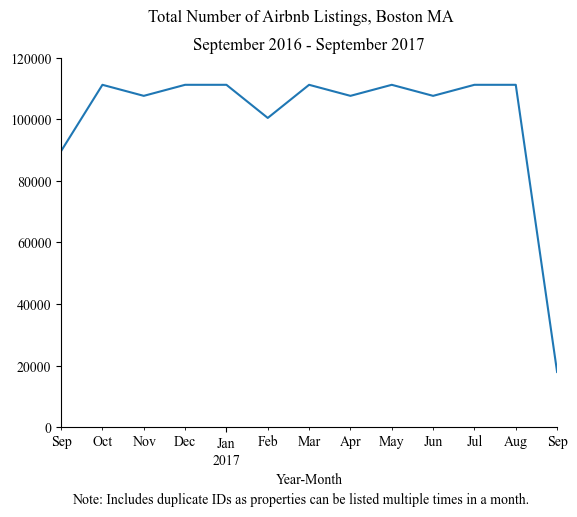

In [112]:
#1) Create a line plot of the total number of listings per year-month

#Count the total number of listings per month
total_listings = cal_lis.groupby("year_month")["id"].count().reset_index()
total_listings.rename(columns={"id":"total_listings"}, inplace=True)

#Create the line plot
#Create figure and plot space
fig, ax = plt.subplots()
#Plot the count of total listings by year-month
total_listings.plot(x="year_month", y="total_listings", kind="line", ax=ax, legend=False)

#Cleaning
#Create title and subtitle
fig.suptitle("Total Number of Airbnb Listings, Boston MA")
ax.set_title("September 2016 - September 2017")
#Label x-axis
ax.set_xlabel("Year-Month")
#Remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#Set y ticks
ax.set_ylim(0, 120000)
#Create note under figure
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be listed multiple times in a month.", 
            ha="center", fontsize=10)
plt.show()

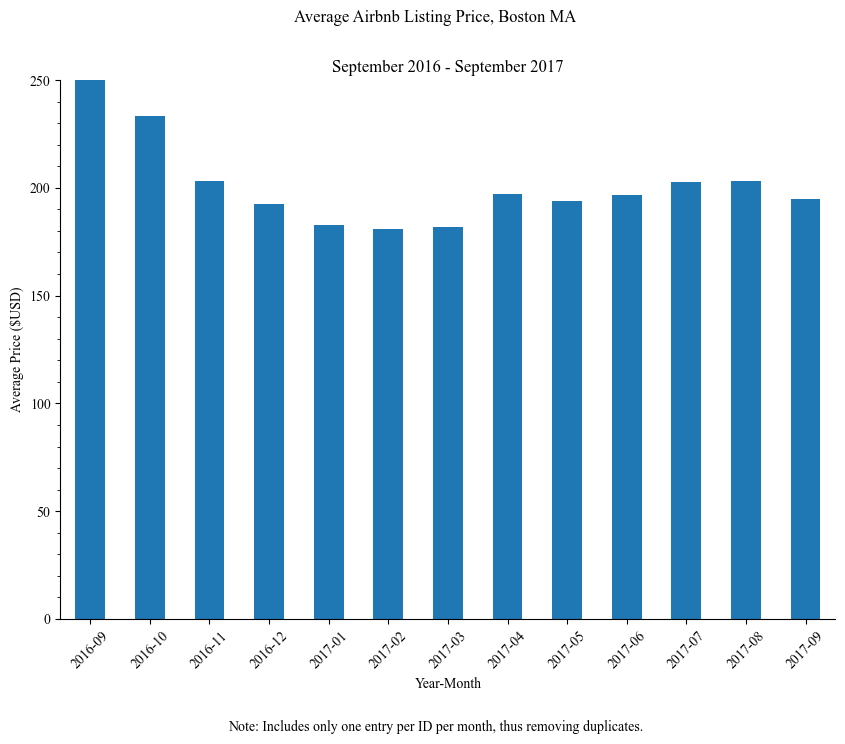

In [113]:
#2) Create a scatter plot of the average listing price per year-month

#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = cal_lis.groupby("year_month")["price"].mean().reset_index()
avg_list_price.rename(columns={"price":"avg_list_price"}, inplace=True)
#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 7))
avg_list_price.plot(x="year_month", y="avg_list_price", kind="bar", ax=ax, legend=False)

#Cleaning
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)
fig.suptitle("Average Airbnb Listing Price, Boston MA")
ax.set_title("September 2016 - September 2017")
ax.set_xlabel("Year-Month")
plt.xticks(rotation=45)
ax.set_ylabel("Average Price ($USD)")
ax.set_ylim(0, 250)
#Set y ticks to incriments of 10, where every 5th tick is major and labelled
ax.set_yticks(np.arange(0, 251, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  
plt.figtext(0.5, -0.05, "Note: Includes only one entry per ID per month, thus removing duplicates.", 
            ha="center", fontsize=10)
plt.show()

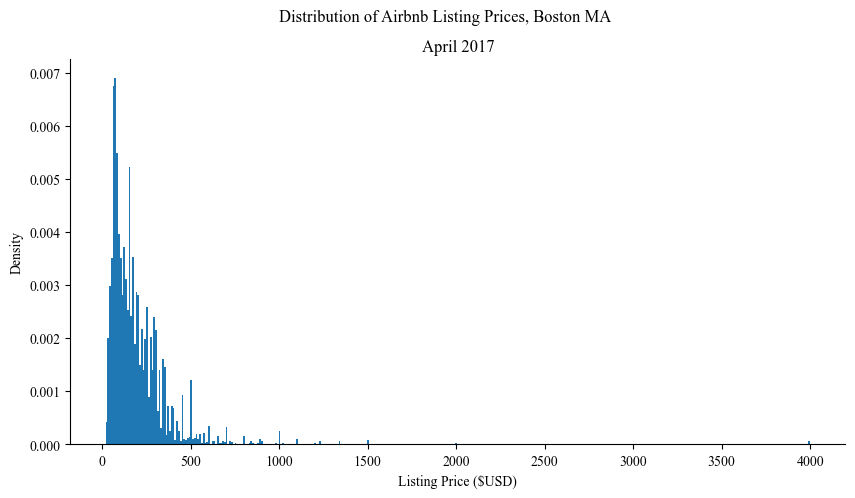

In [114]:
#3) Create a histogram of the distribution of listing prices for April 2017

#Create dataset for only April 2017
df_calendar_temp = cal_lis[cal_lis["year_month"] == "2017-04"]

#Create histogram
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(df_calendar_temp["price"].min(), df_calendar_temp["price"].max(), 400)
df_calendar_temp.plot(kind="hist", y="price", ax=ax, bins=bins, legend=False, density=True) 

#Cleaning
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)
ax.set_ylabel("Density")
ax.set_xlabel("Listing Price ($USD)")
fig.suptitle("Distribution of Airbnb Listing Prices, Boston MA")
ax.set_title("April 2017")
plt.show()

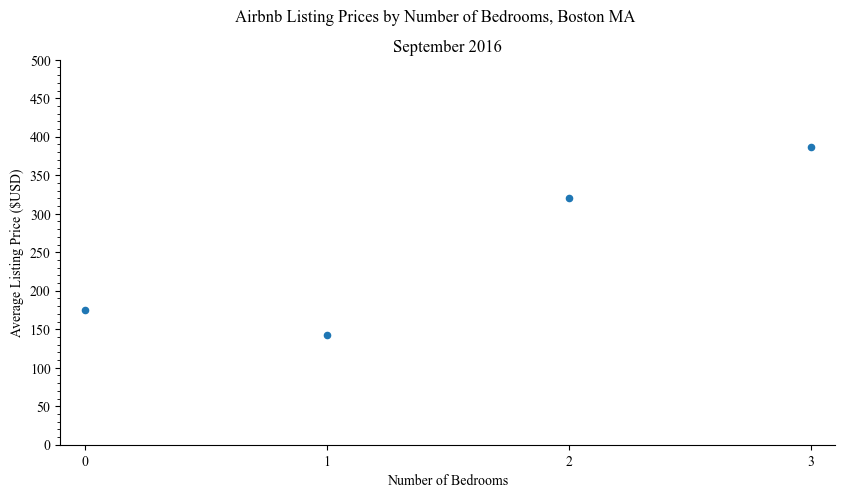

In [111]:
#4) Create a scatterplot of average listing price by number of bedrooms

#Create temp dataset containing only observations from April 2017
df_list_cal_temp = cal_lis[cal_lis["year_month"] == "2017-04"]

#Calculate average listing prie by number of beds
avg_bed_price = df_list_cal_temp.groupby("bedrooms")["price"].mean().reset_index()

#Create scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
avg_bed_price.plot(kind="scatter", y="price", x="bedrooms", ax=ax, legend=False)

#Clean
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)
ax.set_ylabel("Average Listing Price ($USD)")
ax.set_xlabel("Number of Bedrooms")
fig.suptitle("Airbnb Listing Prices by Number of Bedrooms, Boston MA")
ax.set_title("September 2016")
ax.set_ylim(0, 500)
ax.set_xlim(-0.1, 3.1)
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks(np.arange(0, 501, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  

## Conclusion

## Bibliography